<a href="https://colab.research.google.com/github/Plusholic/Bayes_study/blob/main/chap05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating Counts

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12125 sha256=b2822526478bc9767bf69c1dc7873a9dbd9c047eebe3e194022fccd7698515f1
  Stored in directory: /root/.cache/pip/wheels/c2/3f/cf/74b5adbcea4efaae43ce168e622e3eb8dbc1251d5d730dd245
Successfully built empiricaldist


In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

Downloaded utils.py


In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we solved problems that involve estimating proportions.
In the Euro problem, we estimated the probability that a coin lands heads up, and in the exercises, you estimated a batting average, the fraction of people who cheat on their taxes, and the chance of shooting down an invading alien.

Clearly, some of these problems are more realistic than others, and some are more useful than others.

In this chapter, we'll work on problems related to counting, or estimating the size of a population.
Again, some of the examples will seem silly, but some of them, like the German Tank problem, have real applications, sometimes in life and death situations.

## The Train Problem

I found the train problem 
in Frederick Mosteller's, [*Fifty Challenging Problems in
  Probability with Solutions*](https://store.doverpublications.com/0486653552.html):

> "A railroad numbers its locomotives in order 1..N.  One day you see a locomotive with the number 60.  Estimate how many locomotives the railroad has."

Based on this observation, we know the railroad has 60 or more
locomotives.  But how many more?  To apply Bayesian reasoning, we
can break this problem into two steps:

* 데이터를 보기 전에 $N$에 대해서 무엇을 알고 있는가?
* 주어진 모든 $N$의 값에 대해서, 관측한 데이터(60호 기관차)의 가능도는 어떻게 되는가?

첫 번째 질문의 답은 사전확률이고, 두 번째 질문의 답은 가능도다.

We don't have much basis to choose a prior, so we'll start with
something simple and then consider alternatives.
Let's assume that $N$ is equally likely to be any value from 1 to 1000.

Here's the prior distribution:

In [4]:
import numpy as np
from empiricaldist import Pmf

hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

그럼 이제 데이터의 가능도를 구해보자. $N$개의 기관차 가설 집단 중, 60호 기관차를 볼 확률은 얼마나 될까? 각 기관차를 볼 확률이 동일하다고 가정하면, 각각의 기관차를 볼 확률은 $1/N$ 이다.

Here's the function that does the update:

In [5]:
def update_train(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs # N개 기관차의 호수, 여기서는 1호~ 1000호
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

This function might look familiar; it is the same as the update function for the dice problem in the previous chapter.
In terms of likelihood, the train problem is the same as the dice problem.

Here's the update:

In [8]:
data = 60
posterior = prior.copy()
update_train(posterior, data)

Here's what the posterior looks like:

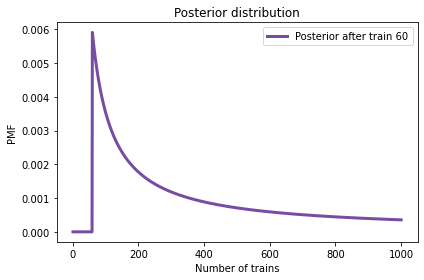

In [9]:
from utils import decorate

posterior.plot(label='Posterior after train 60', color='C4')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distribution')

Not surprisingly, all values of $N$ below 60 have been eliminated.

The most likely value, if you had to guess, is 60.

In [10]:
posterior.max_prob()

60

That might not seem like a very good guess; after all, what are the chances that you just happened to see the train with the highest number?
Nevertheless, if you want to maximize the chance of getting
the answer exactly right, you should guess 60.

하지만 이는 목적에 들어맞는 방법은 아니다. 그래서 대안으로 사후확률 분포의 평균을 구할 수 있다. 주어진 가능한 수$q_i$와 이에 대한 확률$p_i$에 대해, 분포의 평균값은 다음과 같다.

$$\mathrm{mean} = \sum_i p_i q_i$$

이 값은 다음과 같이 구할 수 있다.

In [11]:
np.sum(posterior.ps * posterior.qs)

333.41989326370776

Or we can use the method provided by `Pmf`:

In [12]:
posterior.mean()

333.41989326370776

The mean of the posterior is 333, so that might be a good guess if you want to minimize error.
If you played this guessing game over and over, using the mean of the posterior as your estimate would minimize the [mean squared error](http://en.wikipedia.org/wiki/Minimum_mean_square_error) over the long run.

## Sensitivity to the Prior

The prior I used in the previous section is uniform from 1 to 1000, but I offered no justification for choosing a uniform distribution or that particular upper bound.
We might wonder whether the posterior distribution is sensitive to the prior.
With so little data---only one observation---it is.

This table shows what happens as we vary the upper bound:

In [13]:
import pandas as pd

df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


As we vary the upper bound, the posterior mean changes substantially.
So that's bad.  

When the posterior is sensitive to the prior, there are two ways to proceed:

* Get more data.

* Get more background information and choose a better prior.

데이터를 더 확보하면, 서로 다른 사전확률분포 기반으로 만들어진 사후확률 분포가 수렴하는 양상을 띈다. 예를 들어, 60번 기관차를 본 후 30번과 90번 기관차를 봤다고 해보자.

다음의 세 기차를 본 후의 전 확률의 상한값에 따른 사후확률 분포의 평균값을 살펴보자.

In [15]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


The differences are smaller, but apparently three trains are not enough for the posteriors to converge.

## Power Law Prior

만약 데이터를 더 확보할 수 없다면, 다른 옵션으로 배경 지식을 더 수집해서 사전확률을 개선하는 방식이 있다. 기관차 운영 회사가 1000대의 기관차를 운영한다고 가정하는 것은 철도 회사가 세상에 단 하나뿐이라고 생각하는 것만큼이나 비합리적이다.

With some effort, we could probably find a list of companies that
operate locomotives in the area of observation.
Or we could interview an expert in rail shipping to gather information about the typical size of companies.

But even without getting into the specifics of railroad economics, we
can make some educated guesses.
In most fields, there are many small companies, fewer medium-sized companies, and only one or two very large companies.

In fact, the distribution of company sizes tends to follow a power law, as Robert Axtell reports in *Science* (<http://www.sciencemag.org/content/293/5536/1818.full.pdf>).

This law suggests that if there are 1000 companies with fewer than
10 locomotives, there might be 100 companies with 100 locomotives,
10 companies with 1000, and possibly one company with 10,000 locomotives.

수학적으로, 멱법칙은 주어진 규모 $N$인 회사의 수는 $(1/N)^{\alpha}$에 비례한다는 뜻이다. 이 때 $\alpha$는 1에 가까운 크기의 매개변수다.

We can construct a power law prior like this:

In [16]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

8.178368103610282

For comparison, here's the uniform prior again.

In [17]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

Here's what a power law prior looks like, compared to the uniform prior:

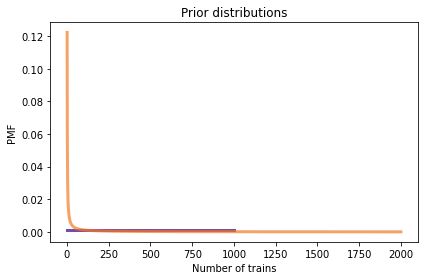

In [18]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')

Here's the update for both priors.

In [19]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

And here are the posterior distributions.

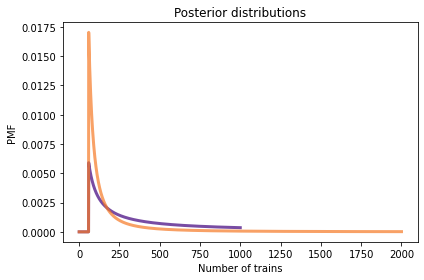

In [20]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions')

The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.

Here's how the posterior means depend on the upper bound when we use a power law prior and observe three trains:

In [21]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


Now the differences are much smaller.  In fact,
with an arbitrarily large upper bound, the mean converges on 134.

So the power law prior is more realistic, because it is based on
general information about the size of companies, and it behaves better in practice.

## Credible Intervals

So far we have seen two ways to summarize a posterior distribution: the value with the highest posterior probability (the MAP) and the posterior mean.
These are both **point estimates**, that is, single values that estimate the quantity we are interested in.

Another way to summarize a posterior distribution is with percentiles.
If you have taken a standardized test, you might be familiar with percentiles.
For example, if your score is the 90th percentile, that means you did as well as or better than 90\% of the people who took the test.

If we are given a value, `x`, we can compute its **percentile rank** by finding all values less than or equal to `x` and adding up their probabilities.

`Pmf` 는 이 계산을 하는 메소드를 제공한다. 예를 들어, 100개 이하의 기관차를 가진 회사의 확률을 구하고 싶다고 하면 다음과 같이 구할 수 있다.

In [22]:
power.prob_le(100)

0.2937469222495771

With a power law prior and a dataset of three trains, the result is about 29%.
So 100 trains is the 29th percentile.

Going the other way, suppose we want to compute a particular percentile; for example, the median of a distribution is the 50th percentile.
We can compute it by adding up probabilities until the total exceeds 0.5.
Here's a function that does it:

In [23]:
def quantile(pmf, prob):
    """Compute a quantile with the given prob."""
    total = 0
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

The loop uses `items`, which iterates the quantities and probabilities in the distribution.
Inside the loop we add up the probabilities of the quantities in order.
When the total equals or exceeds `prob`, we return the corresponding quantity.

This function is called `quantile` because it computes a quantile rather than a percentile.
The difference is the way we specify `prob`.
If `prob` is a percentage between 0 and 100, we call the corresponding quantity a percentile.
If `prob` is a probability between 0 and 1, we call the corresponding quantity a **quantile**.

Here's how we can use this function to compute the 50th percentile of the posterior distribution:

In [24]:
quantile(power, 0.5)

113

결과인 113개의 기관차는 사후확률 분포의 중간값이다.

`Pmf` provides a method called `quantile` that does the same thing.
We can call it like this to compute the 5th and 95th percentiles:

In [26]:
power.quantile([0.05, 0.95])

array([ 91., 243.])

결과는 91대에서 243대 기관차 사이다. 이 결과가 의미하는 것은 다음과 같다.

* 기관차의 수가 91 이하일 확률은 5%다.
* 기관차의 수가 243보다 클 확률은 5%다.

따라서 기관차의 수가 91 초과 243 이하일 확률은 90%이다. 그래서 이 구간을 90% 신뢰구간이라고 한다.

`Pmf` also provides `credible_interval`, which computes an interval that contains the given probability.

In [ ]:
power.credible_interval(0.9)

## The German Tank Problem

During World War II, the Economic Warfare Division of the American
Embassy in London used statistical analysis to estimate German
production of tanks and other equipment.

The Western Allies had captured log books, inventories, and repair
records that included chassis and engine serial numbers for individual
tanks.

Analysis of these records indicated that serial numbers were allocated
by manufacturer and tank type in blocks of 100 numbers, that numbers
in each block were used sequentially, and that not all numbers in each
block were used.  So the problem of estimating German tank production
could be reduced, within each block of 100 numbers, to a form of the
train problem.

Based on this insight, American and British analysts produced
estimates substantially lower than estimates from other forms
of intelligence.  And after the war, records indicated that they were
substantially more accurate.

They performed similar analyses for tires, trucks, rockets, and other
equipment, yielding accurate and actionable economic intelligence.

The German tank problem is historically interesting; it is also a nice
example of real-world application of statistical estimation.

For more on this problem, see [this Wikipedia page](https://en.wikipedia.org/wiki/German_tank_problem) and Ruggles and Brodie, "An Empirical Approach to Economic Intelligence in World War II", *Journal of the American Statistical Association*, March 1947, [available here](https://web.archive.org/web/20170123132042/https://www.cia.gov/library/readingroom/docs/CIA-RDP79R01001A001300010013-3.pdf).

## Informative Priors

Among Bayesians, there are two approaches to choosing prior
distributions.  Some recommend choosing the prior that best represents
background information about the problem; in that case the prior
is said to be **informative**.  The problem with using an informative
prior is that people might have different information or
interpret it differently.  So informative priors might seem arbitrary.

The alternative is a so-called **uninformative prior**, which is
intended to be as unrestricted as possible, in order to let the data
speak for itself.  In some cases you can identify a unique prior
that has some desirable property, like representing minimal prior
information about the estimated quantity.

Uninformative priors are appealing because they seem more
objective.  But I am generally in favor of using informative priors.
Why?  First, Bayesian analysis is always based on
modeling decisions.  Choosing the prior is one of those decisions, but
it is not the only one, and it might not even be the most subjective.
So even if an uninformative prior is more objective, the entire analysis is still subjective.

또 가장 실질적인 문제로, 보통 데이터가 굉장히 많거나 별로 없거나 하는 두 가지 상황 중 하나에 처해 있을 경우가 많다. 많약 데이터가 굉장히 많은 경우라면, 사전확률 분포를 무엇으로 고르든지 상관없다. 사전확률 분포가 정보성이든, 비정보성이든 거의 유사한 결과를 도출한다. 데이터가 별로 없다면, 관련 배경 지식 (멱법칙 분포 등)을 사용하면 큰 차이가 난다.

And if, as in the German tank problem, you have to make life and death
decisions based on your results, you should probably use all of the
information at your disposal, rather than maintaining the illusion of
objectivity by pretending to know less than you do.

## Summary

This chapter introduces the train problem, which turns out to have the same likelihood function as the dice problem, and which can be applied to the German Tank problem.
In all of these examples, the goal is to estimate a count, or the size of a population.

In the next chapter, I'll introduce "odds" as an alternative to probabilities, and Bayes's Rule as an alternative form of Bayes's Theorem.
We'll compute distributions of sums and products, and use them to estimate the number of Members of Congress who are corrupt, among other problems.

But first, you might want to work on these exercises.

## Exercises

**Exercise:** Suppose you are giving a talk in a large lecture hall and the fire marshal interrupts because they think the audience exceeds 1200 people, which is the safe capacity of the room. 

You think there are fewer then 1200 people, and you offer to prove it.
It would take too long to count, so you try an experiment:

* You ask how many people were born on May 11 and two people raise their hands.  

* You ask how many were born on May 23 and 1 person raises their hand.  
* Finally, you ask how many were born on August 1, and no one raises their hand.

How many people are in the audience?  What is the probability that there are more than 1200 people.
Hint: Remember the binomial distribution.

In [97]:
# Solution goes here
hypos = np.arange(1, 2000)
prior = Pmf(1, hypos) # 사전확률 uniform 하게 정의
prior.normalize()

200

In [98]:
# Solution goes here
from scipy.stats import binom

likelihood1 = binom.pmf(2, hypos, 1/365) # 2명이 서로 생일이 같은 경우를 체크
likelihood2 = binom.pmf(1, hypos, 1/365) 
likelihood3 = binom.pmf(0, hypos, 1/365)

In [95]:
# Solution goes here
posterior = prior * likelihood1 * likelihood2 * likelihood3
posterior.normalize()

0.006762190887651753

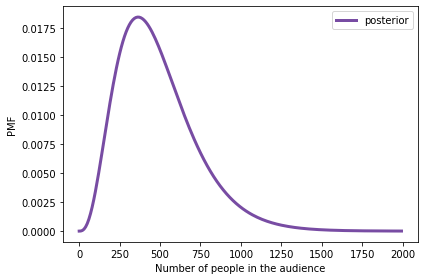

In [76]:
# Solution goes here
posterior.plot(color='C4', label='posterior')
decorate(xlabel='Number of people in the audience',
         ylabel='PMF')

In [62]:
# Solution goes here
posterior.mean()

486.2278641524632

In [63]:
# Solution goes here
posterior.prob_gt(1200)

0.011237085194742136

**Exercise:** I often see [rabbits](https://en.wikipedia.org/wiki/Eastern_cottontail) in the garden behind my house, but it's not easy to tell them apart, so I don't really know how many there are.

Suppose I deploy a motion-sensing [camera trap](https://en.wikipedia.org/wiki/Camera_trap) that takes a picture of the first rabbit it sees each day.  After three days, I compare the pictures and conclude that two of them are the same rabbit and the other is different.

How many rabbits visit my garden?

To answer this question, we have to think about the prior distribution and the likelihood of the data:

* I have sometimes seen four rabbits at the same time, so I know there are at least that many.  I would be surprised if there were more than 10.  So, at least as a starting place, I think a uniform prior from 4 to 10 is reasonable.

* To keep things simple, let's assume that all rabbits who visit my garden are equally likely to be caught by the camera trap in a given day.  Let's also assume it is guaranteed that the camera trap gets a picture every day.

In [33]:
# Solution goes here
hypos = np.arange(4, 11)
prior = Pmf(1, hypos)

In [34]:
# Solution goes here
N = hypos
likelihood = (N-1) / N**2

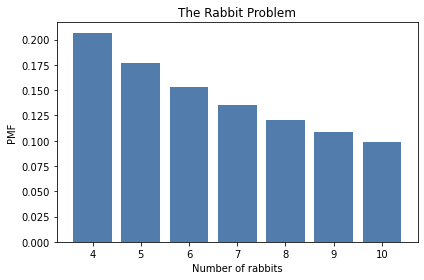

In [35]:
# Solution goes here
posterior = prior * likelihood
posterior.normalize()

posterior.bar(alpha=0.7)
decorate(xlabel='Number of rabbits',
         ylabel='PMF',
         title='The Rabbit Problem')

**Exercise:** Suppose that in the criminal justice system, all prison sentences are either 1, 2, or 3 years, with an equal number of each.  One day, you visit a prison and choose a prisoner at random.  What is the probability that they are serving a 3-year sentence?  What is the average remaining sentence of the prisoners you observe?

In [64]:
# Solution goes here
hypos = np.arange(1, 4)
prior = Pmf(1/3, hypos)
prior

,probs
1,0.333333
2,0.333333
3,0.333333


In [37]:
# Solution goes here
likelihood = hypos
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
1,0.166667
2,0.333333
3,0.500000


In [38]:
# Solution goes here
posterior.mean() / 2

1.1666666666666665

**Exercise:** If I chose a random adult in the U.S., what is the probability that they have a sibling?  To be precise, what is the probability that their mother has had at least one other child.

[This article from the Pew Research Center](https://www.pewsocialtrends.org/2015/05/07/family-size-among-mothers/) provides some relevant data.  

From it, I extracted the following distribution of family size for mothers in the U.S. who were 40-44 years old in 2014:

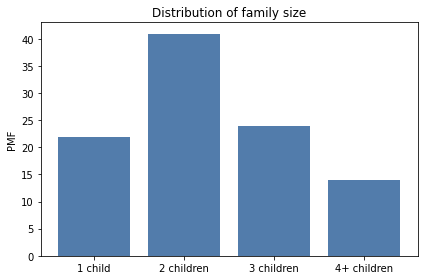

In [45]:
import matplotlib.pyplot as plt

qs = [1, 2, 3, 4]
ps = [22, 41, 24, 14]
prior = Pmf(ps, qs)
prior.bar(alpha=0.7)

plt.xticks(qs, ['1 child', '2 children', '3 children', '4+ children'])
decorate(ylabel='PMF',
         title='Distribution of family size')

For simplicity, let's assume that all families in the 4+ category have exactly 4 children.

In [46]:
# Solution goes here
likelihood = qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
1,0.094828
2,0.353448
3,0.310345
4,0.241379


In [47]:
# Solution goes here
1 - posterior[1]

0.9051724137931034

In [48]:
# Solution goes here
posterior.prob_gt(1)

0.9051724137931034

**Exercise:** The [Doomsday argument](https://en.wikipedia.org/wiki/Doomsday_argument) is "a probabilistic argument that claims to predict the number of future members of the human species given an estimate of the total number of humans born so far."

Suppose there are only two kinds of intelligent civilizations that can happen in the universe.  The "short-lived" kind go exinct after only 200 billion individuals are born.  The "long-lived" kind survive until 2,000 billion individuals are born.
And suppose that the two kinds of civilization are equally likely.
Which kind of civilization do you think we live in?  

The Doomsday argument says we can use the total number of humans born so far as data.
According to the [Population Reference Bureau](https://www.prb.org/howmanypeoplehaveeverlivedonearth/), the total number of people who have ever lived is about 108 billion.

Since you were born quite recently, let's assume that you are, in fact, human being number 108 billion.
If $N$ is the total number who will ever live and we consider you to be a randomly-chosen person, it is equally likely that you could have been person 1, or $N$, or any number in between.
So what is the probability that you would be number 108 billion?

Given this data and dubious prior, what is the probability that our civilization will be short-lived?

In [100]:
# Solution goes here
hypos = [200, 2000]
prior = Pmf(1, hypos)

In [101]:
# Solution goes here
likelihood = 1/prior.qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
200,0.909091
2000,0.090909


In [ ]:
# Solution goes here